In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import wrangle as w

In [2]:
df = w.wrangle_pola()
df

,num_at_anchor,num_at_berth,departed,avg_days_at_berth,avg_days_anchor_berth
date,,,,,
2015-03-17,15.0,16.0,5.0,4.0,9.4
2015-03-18,12.0,16.0,3.0,5.3,6.0
2015-03-19,13.0,17.0,5.0,5.6,12.2
2015-03-20,10.0,16.0,5.0,2.4,3.8
2015-03-23,8.0,15.0,2.0,4.0,15.5
...,...,...,...,...,...
2019-01-30,0.0,11.0,5.0,2.6,3.4
2019-01-31,0.0,10.0,5.0,3.0,3.0
2019-02-01,0.0,12.0,1.0,3.0,3.0


<Axes: xlabel='date'>

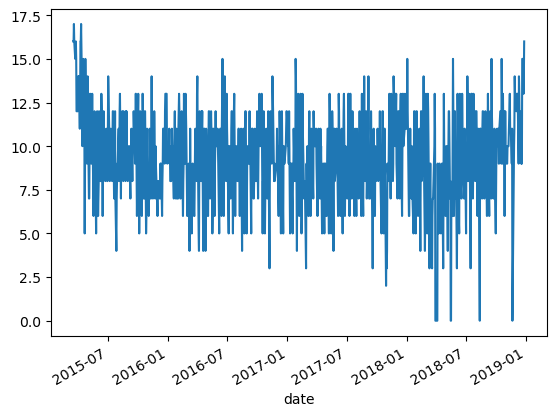

In [21]:
df.num_at_berth.plot()

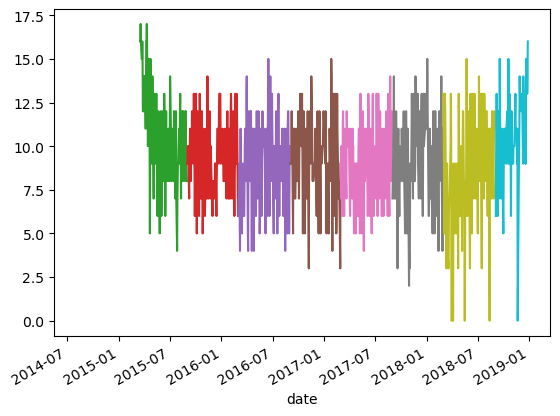

In [19]:
df.resample("6M").num_at_berth.plot();
# plt.xlim('2016-01', '2017-01')

In [6]:
def split_pola(df):    
    train = df.iloc[:round(len(df)*.7)]
    val = df.iloc[round(len(df)*.7):round(len(df)*.85)]
    test = df.iloc[round(len(df)*.85):]
    return train, val, test

In [7]:
train, val, test = split_pola(df)

In [8]:
print(f"""
{df.shape[0]}
{train.shape[0] + val.shape[0] + test.shape[0]}
""")


942
942



<Axes: xlabel='date'>

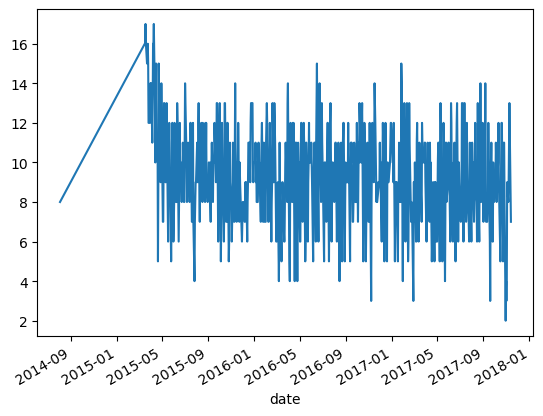

In [9]:
train.num_at_berth.plot()

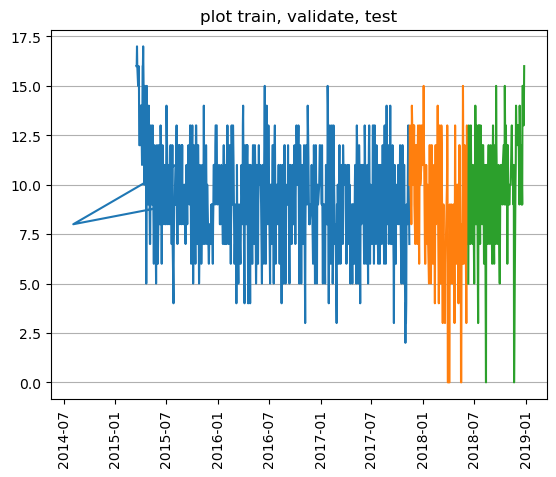

In [10]:
# Plot the dataframes
plt.plot(train.index, train.num_at_berth)
plt.plot(val.index, val.num_at_berth)
plt.plot(test.index, test.num_at_berth)
plt.title('plot train, validate, test')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

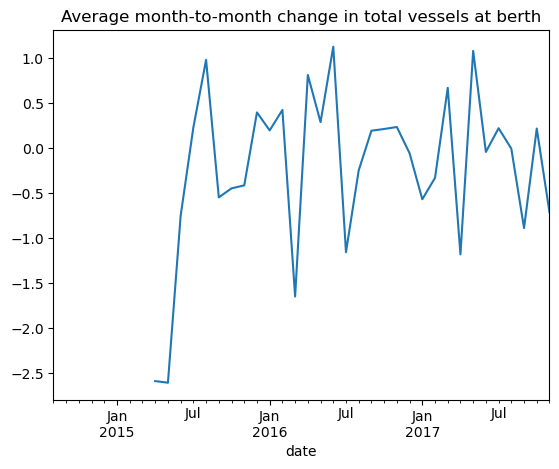

In [11]:
# Average change in total sales
train.resample('M').mean().num_at_berth.diff().plot(title='Average month-to-month change in total vessels at berth');

<Axes: xlabel='date'>

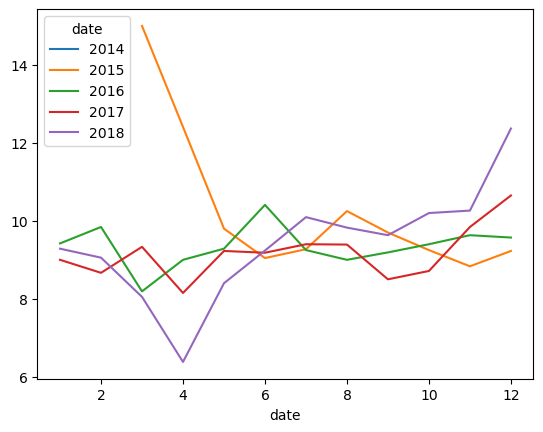

In [12]:
df.groupby([df.index.year, df.index.month]).mean().unstack(0).num_at_berth.plot(title='')

# Plot Autocorrelation

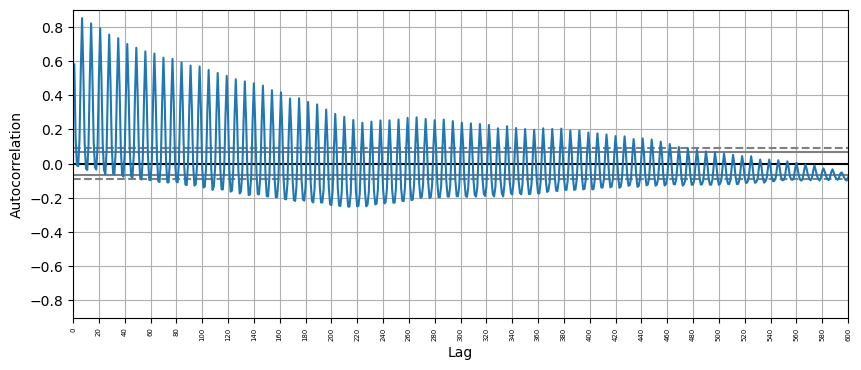

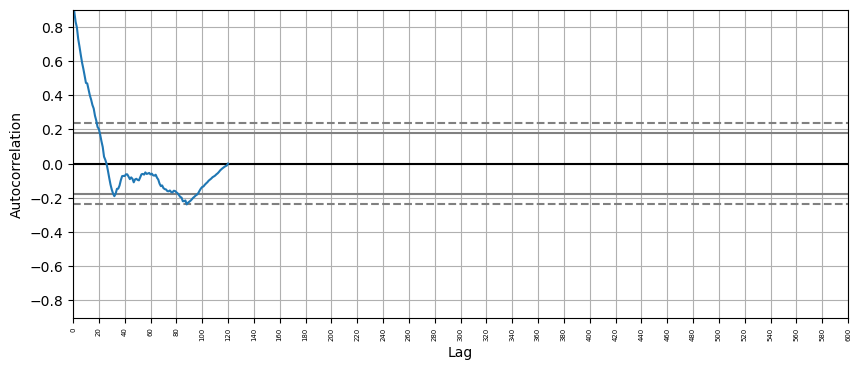

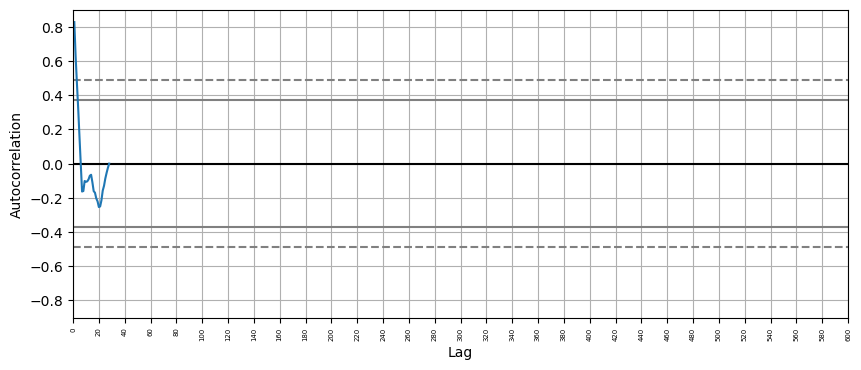

In [13]:
timescales = ['D', 'W', 'M']
for scale in timescales:
    df_resampled = pd.DataFrame(train.resample(scale).num_at_berth.agg('sum'))
    plot_train, _ , _ = split_pola(df_resampled)
    plt.figure(figsize=(10,4))
    pd.plotting.autocorrelation_plot(plot_train.num_at_berth)
    plt.xlim(0,600)
    plt.xticks(range(0, 601, 20), rotation=90, fontsize=5)
    plt.ylim(-.9,.9)
    plt.show()

## Observations:
- The daily timescale shows significant autocorrelation up to a lag of 800 days
- The weekly timescale show no significant autocorrelation
- The monthly timescale shows no significant autocorrelation

- Signal is lossed in resampling this data because it follows an irregular 5 day work week cycle (holidays frequently disrupt the schedule). For instance, the daily sampled data loses significance around one year, the weekly sampled data around 5 months, and the monthly sampled data around 2 months.

In [9]:
import requests
import tabula
import os

In [10]:
pdf_url = f"https://kentico.portoflosangeles.org/getmedia/a39485f1-46e4-44cd-98ff-d772cb663174/port-of-los-angeles-container-vessel-activity-summary-2019"
# Send an HTTP GET request to the URL
response = requests.get(pdf_url)
# Check if the request was successful
if response.status_code == 200:
    # Get the filename from the URL
    filename = 'pola' + pdf_url.split("/")[-1].split('-')[-1] + '.pdf'
    # Save the PDF content to a local file
    with open(filename, "wb") as pdf_file:
                pdf_file.write(response.content)
else:
    print("Failed to retrieve the PDF.")
# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame()

pdf_file_path = f'pola2019.pdf'

# Extract tables from the PDF and return a list of DataFrames
tables = tabula.read_pdf(pdf_file_path, pages='all', multiple_tables=True)

# Initialize an empty DataFrame for each year
df = pd.DataFrame()
for idx, table in enumerate(tables):
    df = pd.concat([df, pd.DataFrame(table)], axis=0)

# Drop the 'Unnamed: 0' column if present
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns='Unnamed: 0')

# Drop null rows
df = df.dropna()

# Concatenate the DataFrames for different years
results_df = pd.concat([results_df, df], axis=0)

# Remove the processed PDF file
os.remove(pdf_file_path)

results_df = results_df.reset_index().drop(columns='index')


In [18]:
# results_df.iloc[200:-1]

In [ ]:
#24 needs fixing

In [26]:
def prep_pola(df):
    
    # Change the 2014-08-04 value to 2015-08-04
    df.iloc[97].date = '8/4/2015'
    
    # Set the date column as the datetime index
    df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
 
    # Convert column values to floats
    for col in df.columns:
        df[col] = df[col].astype(float)

    return df

In [29]:
############ INITIAL IMPORTS ###########

import os
import requests
import pandas as pd
import tabula
import warnings

def wrangle_pola():    
    """
    Reads in the POLA data. From the csv if it's already there and if not, it downloads the data from the Port of Los Angeles
    website as pdfs, converts them to dataframes, concatenates them, deletes the original pdfs, and saves the combined data
    in a csv file called 'pola.csv'
    """
    # Check if the 'pola.csv' file already exists
    if os.path.exists('pola.csv'):
        # If the file exists, read the data from the CSV file
        results_df = pd.read_csv('pola.csv')
        results_df = prep_pola(results_df)
        
    else:
        # List of URLs for the PDFs to download and process
        lst = [
            "a39485f1-46e4-44cd-98ff-d772cb663174/port-of-los-angeles-container-vessel-activity-summary-2019",
            "1a8f2a5f-8d5f-4262-a1f8-2de701fc1bda/Port-of-Los-Angeles-Container-Vessel-Activity-Summary-2018",
            "517cbd39-d632-489d-bddf-87750ca1ccb5/Port-of-Los-Angeles-Container-Vessel-Activity-Summary-2017",
            "2d907886-b866-4610-9c62-b4171662ddad/Port-of-Los-Angeles-Container-Vessel-Activity-Summary-2016",
            "79aeef2f-c3e8-4277-82c3-c5eccc2492e2/Port-of-Los-Angeles-Container-Vessel-Activity-Summary-2015"
        ]

        # Loop through the list of URLs and download PDFs
        for i in lst:
            pdf_url = f"https://kentico.portoflosangeles.org/getmedia/{i}"
            # Send an HTTP GET request to the URL
            response = requests.get(pdf_url)
            # Check if the request was successful
            if response.status_code == 200:
                # Get the filename from the URL
                filename = 'pola' + pdf_url.split("/")[-1].split('-')[-1] + '.pdf'
                # Save the PDF content to a local file
                with open(filename, "wb") as pdf_file:
                    pdf_file.write(response.content)
            else:
                print("Failed to retrieve the PDF.")
        # Initialize an empty DataFrame to store the results
        results_df = pd.DataFrame()

        # Loop through years (2015-2019) to process PDFs
        for i in range(5, 10):
            # Path to the PDF file
            pdf_file_path = f'pola201{i}.pdf'

            # Extract tables from the PDF and return a list of DataFrames
            tables = tabula.read_pdf(pdf_file_path, pages='all', multiple_tables=True)

            # Initialize an empty DataFrame for each year
            df = pd.DataFrame()
            for idx, table in enumerate(tables):
                df = pd.concat([df, pd.DataFrame(table)], axis=0)

            # Drop the 'Unnamed: 0' column if present
            if 'Unnamed: 0' in df.columns:
                df = df.drop(columns='Unnamed: 0')

            # Drop null rows
            df = df.dropna()

            # Concatenate the DataFrames for different years
            results_df = pd.concat([results_df, df], axis=0)

            # Remove the processed PDF file
            os.remove(pdf_file_path)

        results_df = results_df.reset_index().drop(columns='index')

        fix_list = [124, 172,968]

        for i in fix_list:
            values = []
            for j in range(len(results_df.columns)):
                values.append(results_df.values[i].tolist()[j].split('\r'))

            temp_df = pd.DataFrame({
                'Date': [values[0][0], values[0][1]],
                'POLA Vessels at\rAnchor' : [values[1][0], values[1][1]],
                'POLA Vessels at\rBerth': [values[2][0], values[2][1]],
                'POLA Vessels\rDeparted': [values[3][0], values[3][1]],
                'Average Days at\rBerth': [values[4][0], values[4][1]],
                'Average Days at\rANC + Berth': [values[5][0], values[5][1]]
                })

            results_df = pd.concat([results_df.iloc[:i], temp_df, results_df[i+1:]], axis=0).reset_index(drop=True)
       
        # Rename columns for readability
        results_df = results_df.rename(columns={'Date':'date',
                   'POLA Vessels at\rAnchor':'num_at_anchor', 
                   'POLA Vessels at\rBerth':'num_at_berth',
                   'POLA Vessels\rDeparted':'departed',
                   'Average Days at\rBerth':'avg_days_at_berth',
                   'Average Days at\rANC + Berth':'avg_days_anchor_berth'})
        
        # Save the dataframe to a csv in the working directory named 'pola.csv'
        results_df.to_csv('pola.csv', index=False)
        
        results_df = prep_pola(results_df)
        
    return results_df

In [3]:
df = w.wrangle_pola()

In [4]:
df.iloc[-50:-1]

,num_at_anchor,num_at_berth,departed,avg_days_at_berth,avg_days_anchor_berth
date,,,,,
2018-11-20,0.0,11.0,3.0,3.00,3.00
2018-11-21,0.0,0.0,2.0,3.00,3.00
2018-11-26,0.0,10.0,1.0,8.00,8.00
2018-11-27,0.0,11.0,4.0,4.50,4.50
2018-11-28,0.0,14.0,2.0,3.00,3.00
2018-11-29,0.0,13.0,2.0,1.00,1.00
2018-11-30,0.0,13.0,0.0,0.00,0.00
2018-12-03,0.0,12.0,4.0,4.25,4.25
2018-12-04,0.0,13.0,4.0,4.00,4.00
